In [1]:
from utils import*

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras import backend as K


Using TensorFlow backend.


In [80]:
####################################################################################################################################################
def load_data(markers_file_path, markers_color, window_length=11):
    raw_df  = pd.read_csv(
        markers_file_path,                                                  # relative python path to subdirectory
        usecols = ['time', markers_color],                             # Only load the three columns specified.
        parse_dates = ['time'] )         

    # Time
    date_time = pd.to_datetime( raw_df['time'] , format=datime_format)
    time = [ np.round( (datetime.combine(date.min, t.time())-datetime.min).total_seconds(), 2) for t in date_time]
    time = time-time[0]

    # Markers
    markers = [list(map(float, l.replace(']','').replace('[','').replace('\n','').split(", "))) for l in raw_df[markers_color].values]  
    markers_npy = np.array(markers).reshape(len(time), -1, 3)
    # DON'T Smooth markers. markers can be switched in array and smoothing causes error    

    # Center    
    center = np.mean(markers_npy, axis=1)         
    center = np.nan_to_num(center)
    center = signal.savgol_filter( center, window_length=window_length, polyorder=1, axis=0)     

   # Norm
    norm = np.cross( markers_npy[:,1,:] - markers_npy[:,0,:], markers_npy[:,2,:] - markers_npy[:,0,:])
    norm = norm / ( np.reshape(np.linalg.norm(norm, axis=1), (-1,1)) * np.ones((1,3)))
    # DOn't smooth norm 
    
    time_new = np.arange(0, 35, .1)
    center_new, norm_new = np.zeros((len(time_new),3)), np.zeros((len(time_new),3))
    resampler_kind = 'linear'
    for i in range(3):
        resampler = interpolate.interp1d(time, center[:,i], kind=resampler_kind)
        c_new =  np.nan_to_num( resampler(time_new) )
        center_new[:,i] = signal.savgol_filter( c_new, window_length=window_length, polyorder=1, axis=0)     

        resampler = interpolate.interp1d(time, norm[:,i], kind=resampler_kind)
        n_new =  np.nan_to_num( resampler(time_new) )
        n_new = signal.savgol_filter( n_new, window_length=window_length, polyorder=1, axis=0)    
        norm_new[:,i] = n_new / np.linalg.norm(n_new)

    return center_new, norm_new
####################################################################################################################################################
def get_rotationMatrix(XrotAngle, YrotAngle, ZrotAngle):
    Rx = np.array([ [1, 0,0], [0, cos(XrotAngle), -sin(XrotAngle)], [0, sin(XrotAngle), cos(XrotAngle)] ])
    Ry = np.array([ [cos(YrotAngle), 0, sin(YrotAngle)], [0, 1, 0], [-sin(YrotAngle), 0, cos(YrotAngle)] ])
    Rz = np.array([ [cos(ZrotAngle), -sin(ZrotAngle), 0], [sin(ZrotAngle), cos(ZrotAngle), 0], [0, 0, 1] ])
    Rtotal =  np.matmul(np.matmul(Rz,Ry),Rx)
    return Rtotal
####################################################################################################################################################
def calculate_params(loc_1_, align_1_, loc_2_, align_2_):
    loc_1, loc_2, align_1, align_2 = np.array(loc_1_), np.array(loc_2_), np.array(align_1_), np.array(align_2_)
    
    if align_1[1] == 0: thetaX = 0
    else: thetaX = atan( align_1[1]/align_1[2] )    

    thetaY = atan( -align_1[0] / sqrt(align_1[1]**2 + align_1[2]**2) )
    align_2_new = np.matmul(get_rotationMatrix(thetaX, thetaY, 0), np.reshape(align_2,[3,1]))    
        
    if align_2_new[0] == 0: thetaZ = 0
    else: thetaZ = atan(align_2_new[0]/align_2_new[1])    
    Rtot = get_rotationMatrix(thetaX, thetaY , thetaZ)
    loc_2_new = np.matmul(Rtot, np.reshape(loc_2-loc_1, [3,1]))    
    align_2_new = np.matmul(Rtot, np.reshape(align_2, [3,1]))    

    coilsDistance = abs(np.round(np.reshape(loc_2_new, [1,3])[0], 10))
    xRotAngle = np.round( atan(abs( align_2_new[1]/align_2_new[2] )) * 180/pi )
    # xRotAngle = np.round( atan(-align_2_new[1]/align_2_new[2]) * 180/pi )

    return coilsDistance, xRotAngle
####################################################################################################################################################
def get_dataset(dataset_name):
    N = 10
    motion_data = list()
    folder_path = os.path.dirname( get_markers_file_path(dataset_name,'') )   
    for file_path in list(Path(folder_path).glob('*.csv')):  
        ref_center, ref_norm = load_data(file_path, 'red')
        ref_center, ref_norm = np.mean(ref_center[:N], axis=0), np.mean(ref_norm[:N], axis=0)                   
        
        for color in ['blue','green']:
            center, norm = load_data(file_path, color)
            motion_data_n = list()
            for t in range(center.shape[0]):
                coilsDistance, xRotAngle = calculate_params(ref_center, ref_norm, center[t], norm[t])
                motion_data_n.append( [*coilsDistance, xRotAngle]) 
            motion_data_n = signal.savgol_filter( motion_data_n, window_length=11, polyorder=1, axis=0)     
           
            motion_data.append(motion_data_n)
    return np.array(motion_data)
####################################################################################################################################################
def get_dataset_(dataset_name):
    motion_data = list()
    folder_path = os.path.dirname( get_markers_file_path(dataset_name,'') )   
    for file_path in list(Path(folder_path).glob('*.csv')):  
        for color in ['blue','green']:
            center, norm = load_data(file_path, color)
            motion_data.append( np.concatenate([center,norm], axis=1) )
    return np.array(motion_data)
####################################################################################################################################################



####################################################################################################################################################
def nll(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
####################################################################################################################################################
class KLDivergenceLayer(Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)
    ################################################################################################################################################
    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var - K.square(mu) -  K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs
####################################################################################################################################################
class SYNTHESIZER(object):
    ################################################################################################################################################
    def __init__(self, hiddendim, latentdim, Nt):
        self.hiddendim = hiddendim
        self.latentdim = latentdim
        self.Nt = Nt
        return
    ################################################################################################################################################
    def build(self):
        epsilon_std = 1.0

        x = Input(shape=(self.Nt,))
        h = Dense(self.hiddendim, activation='relu')(x)
        z_mu = Dense(self.latentdim)(h)
        z_log_var = Dense(self.latentdim)(h)
        z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
        z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)
        eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], self.latentdim)))
        z_eps = Multiply()([z_sigma, eps])
        z = Add()([z_mu, z_eps])

        self.encoder = Model(x, z_mu)        
        self.decoder = Sequential([
            Dense(self.hiddendim, input_dim=self.latentdim, activation='relu'),
            Dense(self.Nt, activation='sigmoid') ])
        x_pred = self.decoder(z)

        self.vae = Model(inputs=[x, eps], outputs=x_pred)
        self.vae.compile(optimizer='rmsprop', loss=nll)
        
        return
    ################################################################################################################################################
    def train(self, train_data, epochs=200):
        self.build()
        self.data_range = [np.min(train_data), np.max(train_data)]

        train_data_normalized = (train_data - np.min(train_data)) / (np.max(train_data) - np.min(train_data))
        self.vae.fit(train_data_normalized, train_data_normalized, epochs=epochs, validation_data=(train_data_normalized, train_data_normalized), verbose=0)
        return    
    ################################################################################################################################################
    def generate(self, N, window_length=11):
        codes = np.random.multivariate_normal( [0]*self.latentdim, np.eye(self.latentdim), N)
        synth_data = self.decoder.predict(codes)

        synth_data = signal.savgol_filter( synth_data, window_length=window_length, polyorder=1, axis=1)     

        # synth_data = (synth_data - np.mean(synth_data)) / (np.std(synth_data))
        # synth_data = (synth_data - np.min(synth_data)) / (np.max(synth_data) - np.min(synth_data))
        # synth_data = synth_data * (self.data_range[1]-self.data_range[0]) + self.data_range[0] 
        return synth_data
####################################################################################################################################################

In [81]:
motion_data = get_dataset('dataset_07')

N = 1000
batch_Size, Nt, Nf = motion_data.shape

synth_data = np.zeros((N, Nt, Nf))
synthesizer = SYNTHESIZER( hiddendim=300, latentdim=100, Nt=Nt)

for nf in range(Nf):
    train_data = motion_data[:,:,nf]
    synthesizer.train(train_data, epochs=500)
    synth_data[:,:,nf] = synthesizer.generate(N)
synth_data[:,:,-1] *= 90

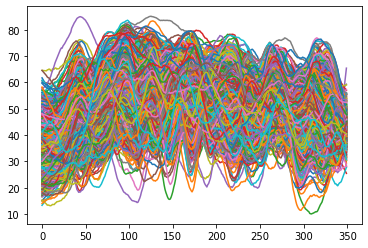

In [3]:
for n in range(1000):
    s = synth_data[n,:,0]
    # s = motion_data[n,:,0]
    plt.plot(s)

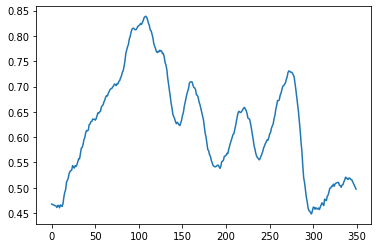

In [88]:
s = synth_data[0,:,3]
plt.plot(s)

(1000, 300, 4)

In [8]:
# Save 
dataset_name = 'dataset_00'
folder_path = '../synthetic_data/' + dataset_name 
create_folder(folder_path+'/motion/record_00.csv')
# .npy
np.save(folder_path + '/motion_data.npy' , synth_data)  
# .csv
for n in range(1000):
    file_name = 'record_' + "{0:0=3d}".format(n) + '.csv'
    np.savetxt( folder_path + '/motion/' + file_name, np.asarray(synth_data[n,:,:]))

In [2]:
dataset_name = 'dataset_00'
folder_path = '../synthetic_data/' + dataset_name 
synth_data = np.load(folder_path+'/motion_data.npy')

In [15]:
for n in range(1000):
    file_name = 'synth_record_' + "{0:0=3d}".format(n) + '.csv'
    np.savetxt('../synthetic_motion/'+file_name, np.asarray(synth_data[n,:,:]))

In [16]:
# np.savetxt('../synthetic_motion/synth_motion_data.csv', np.asarray(synth_data))

In [43]:
motion_data = get_dataset('dataset_07')

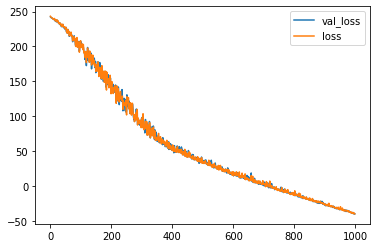

In [77]:
train_data = motion_data[:,:,0]

batch_size, original_dim = train_data.shape
intermediate_dim = 5
latent_dim = 2
epochs = 1000
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):
    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_batch = - .5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
        self.add_loss(K.mean(kl_batch), inputs=inputs)
        return inputs


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='tanh')(x)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)
eps = Input(tensor=K.random_normal(stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

encoder = Model(x, z_mu)
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='tanh'),
    Dense(original_dim, activation='sigmoid')])

x_pred = decoder(z)
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

hist = vae.fit(
        train_data,
        train_data,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(train_data, train_data),
        verbose=0 )
pd.DataFrame(hist.history).plot() 


In [78]:
# # Display a 2D plot of the digit classes in the latent space
# z_test = encoder.predict(train_data, batch_size=batch_size)
# plt.figure(figsize=(6, 6))
# plt.scatter(z_test[:, 0], z_test[:, 1], alpha=.4, s=3**2, cmap='viridis')
# plt.colorbar()
# plt.show()

In [80]:
# display a 2D manifold of the digits
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z, since the prior of the latent space is Gaussian
N = 10  

synth_data = decoder.predict(np.random.multivariate_normal( [0]*latent_dim, np.eye(latent_dim), N))


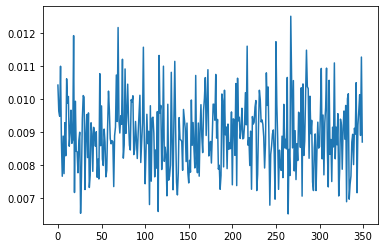

In [83]:
s = synth_data[1]
# s = signal.savgol_filter( s, window_length=25, polyorder=1, axis=0)    
plt.plot(s)

In [105]:
N = 10  
z1 = norm.ppf(np.linspace(0.01, 0.99, N))
z2 = norm.ppf(np.linspace(0.01, 0.99, N))
z_grid = np.dstack(np.meshgrid(z1, z2))
synth_data = decoder.predict(z_grid.reshape(N*N, latent_dim)) 
print(np.shape(synth_data))
                     

(100, 350)


In [106]:
encoder.predict(train_data[0])

ValueError: Error when checking input: expected input_39 to have shape (350,) but got array with shape (1,)

In [19]:
# # set the dimensions of the hidden layers
# hiddendim = 8
# latentdim = 6
# L = motion_data.shape[1]*motion_data.shape[2]

# # Encoder 
# inputs = Input(shape=(L, ), name='encoder_input')
# x = Dense(hiddendim, activation='relu')(inputs)
# z_mean = Dense(latentdim, name='z_mean')(x)
# z_sd = Dense(latentdim, name='z_sd')(x)
# z = Lambda(sampling, output_shape=(latentdim,), name='z')([z_mean, z_sd])
# encoder = Model(inputs, [z_mean, z_sd, z], name='encoder')

# # Decoder 
# latent_inputs = Input(shape=(latentdim,), name='z_sampling')
# x = Dense(hiddendim, activation='relu')(latent_inputs)
# outputs = Dense(L, activation='tanh')(x)
# decoder = Model(latent_inputs, outputs, name='decoder')

# # VAE
# outputs = decoder(encoder(inputs)[2])
# vae = Model(inputs, outputs, name='vae_model')

# # reconstruction laoss
# reconstruction_loss = tf.losses.mse(inputs, outputs)
# kl_loss = (K.square(z_mean) + K.square(z_sd) - K.log(K.square(z_sd)) - 1)/2
# kl_loss = K.sum(kl_loss, axis=-1)  # Kullback-Leibler divergence
# vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae.add_loss(vae_loss) # loss function = reconstruction loss + Kullback-Leibler divergence

# vae.compile(optimizer='adam')

In [21]:
# train_data = np.reshape(motion_data, (-1, motion_data.shape[1]*motion_data.shape[2]))
# vae.fit(train_data, epochs=1000, validation_data=(train_data, None), verbose=0)

In [150]:
# mean = [0,0,0,0,0,0]
# cov = [[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]]
# nd = 10
# synth_data = decoder.predict(np.random.multivariate_normal(mean,cov,nd))
# synth_data = np.reshape(synth_data, (-1, 350,4))

In [17]:
# # MATLAB data

# import scipy.io as sio

# dataset_name = 'dataset_07'    
# sys_info = get_sys_info(dataset_name)    
# sys = SYSTEM(system_info=sys_info)

# folder_path = '../' + dataset_name + '/' 
# create_folder(folder_path + 'alaki.alaki')

# for n in range(30):
#     file_name = 'record_' + "{0:0=2d}".format(n)
#     data = sys.reader.get_data(dataset_name, file_name)  

#     for i, tag in enumerate(sys.tags):
#         tag_data = tag.get_data(dataset_name, file_name, ref_node_data=data, full_motion_data=True)
#         tag_data = tag_data.add_suffix('_'+str(i)).rename({'time_'+str(i):'time'}, axis='columns')
#         data = data.merge( tag_data, on='time', how='outer', suffixes=('', '' ), sort=True )

#     data.interpolate(method='nearest', inplace=True)  
#     data.time -= data.time.loc[0]    

#     sio.savemat(folder_path + file_name +'.mat', {name: col.values for name, col in data.items()}) 


In [18]:
# dataset_name = 'dataset_00'

# time_folder_path = main_directory + '/dataset/' + dataset_name + '/kinect/time'
# markers_folder_path = main_directory + '/dataset/' + dataset_name + '/kinect/markers'

# for n in range(30):
#     file_name = 'record_' + "{0:0=2d}".format(n)
    
#     time_file_path = time_folder_path + '/' + file_name + '.txt'   
#     with open(time_file_path , 'r') as f:  lines = f.read().splitlines() 
#     date_time = pd.to_datetime( lines , format=datime_format)
#     time = pd.DataFrame({'time':[t.time() for t in date_time]})
             
#     locations_dict_ = dict()
#     for color in ['red','blue','green']:
#         markers_file_path = markers_folder_path + '/' + file_name + '_' + color +'.txt' 
#         locations = pd.read_csv( markers_file_path, delimiter="\t", header=None, dtype=np.float64).to_numpy()
# #         locations_dict_.update({color: locations})
#         locations_dict_.update({color: list(map(list,locations))})
    
#     locations_dict = defaultdict(list)  
#     for l in range(len(time)):
#         for color in ['red','blue','green']:
#             locations_dict[color].append( locations_dict_[color][l] )                            

#   # MArkers (time and locations)
#     markers = pd.concat([time, pd.DataFrame(locations_dict)], axis=1)

#     # Save 
#     markers_file_path = get_markers_file_path(dataset_name, file_name)
#     create_folder(markers_file_path)
#     markers.to_csv(markers_file_path, index=False)
        